In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging

In [6]:
import os
import pandas as pd
import logging

# --- Data Loading ---
data_filepath = os.path.expanduser('~/work/vaping_project_data/merged_data_g12.csv')
try:
    merged_data = pd.read_csv(data_filepath)
except Exception as e:
    logging.error(f"Data loading failed: {e}")
    raise SystemExit

logging.info("Dataset Info:")
merged_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71712 entries, 0 to 71711
Columns: 163 entries, V2124 to V2156
dtypes: float64(3), int64(160)
memory usage: 89.2 MB


In [7]:
# -----------------------------------------------------------------------------
# Missing Data Analysis
# -----------------------------------------------------------------------------

total_missing = merged_data.isna().sum().sum()
print("\nTotal missing values:", total_missing)

# Count negative values in numeric columns.
numeric_cols = merged_data.select_dtypes(include=[np.number]).columns
negative_counts = merged_data[numeric_cols].apply(lambda x: (x < 0).sum())
negative_counts_df = pd.DataFrame({
    'Column': negative_counts.index,
    'Negative_Count': negative_counts.values
})
print("\nNegative value counts by numeric column:")
print(negative_counts_df)

# Replace negative codes (-9, -8) with NaN.
missing_codes = [-9, -8]
merged_data[numeric_cols] = merged_data[numeric_cols].replace({-9: np.nan, -8: np.nan})

# Compute missing counts and percentages.
missing_counts = merged_data.isna().sum()
missing_percent = (merged_data.isna().mean() * 100).round(2)
missing_summary = pd.DataFrame({
    'Missing_Count': missing_counts,
    'Missing_Percentage': missing_percent
}).sort_values(by='Missing_Percentage', ascending=False)
print("\nMissing values summary:")
print(missing_summary.to_string())


Total missing values: 36428

Negative value counts by numeric column:
    Column  Negative_Count
0    V2124            4577
1    V2030           49423
2    V2178            6111
3    V2188            7290
4       V1               0
..     ...             ...
158    V16               0
159  V2152            2389
160  V2022           51261
161  V2153            5293
162  V2156            4979

[163 rows x 2 columns]

Missing values summary:
                Missing_Count  Missing_Percentage
V2205                   69740               97.25
V2207                   69706               97.20
V2206                   69707               97.20
V2200                   62332               86.92
V2199                   62289               86.86
V2198                   62280               86.85
V2204                   62087               86.58
V2203                   62059               86.54
V2202                   62042               86.52
V2918                   61097               85.20
V2576 

In [22]:
## MICE Imputation
import os
import logging
import pandas as pd
from io import StringIO

# Check if miceforest is installed, install it if not
try:
    from miceforest import ImputationKernel
except ModuleNotFoundError:
    logging.info("miceforest not found. Installing now...")
    import subprocess
    subprocess.check_call(["pip", "install", "miceforest"])
    from miceforest import ImputationKernel
    logging.info("miceforest installed successfully.")

# Set up logging
logging.basicConfig(level=logging.INFO)

# Log dataset information
logging.info("Dataset Info:")
buffer = StringIO()
merged_data.info(buf=buffer)
info_lines = buffer.getvalue().splitlines()
logging.info("\n".join(info_lines))
buffer.close()

# Identify categorical columns (for logging purposes only, not passed to ImputationKernel)
categorical_cols = merged_data.select_dtypes(include=['object', 'category']).columns.tolist()
logging.info(f"Categorical columns identified: {categorical_cols}")

# Create the imputation kernel
# Let miceforest infer categorical variables automatically
kernel = ImputationKernel(
    data=merged_data,
    random_state=42          # For reproducibility
)

# Run the MICE algorithm
logging.info("Starting multiple imputation...")
kernel.mice(iterations=5)    # 5 iterations of the MICE algorithm
logging.info("Multiple imputation completed.")

# Generate imputed datasets
# Simulate 5 datasets by varying the random seed
imputed_datasets = []
for i in range(5):
    kernel_temp = ImputationKernel(
        data=merged_data,
        random_state=42 + i  # Vary seed for each dataset
    )
    kernel_temp.mice(iterations=5)
    imputed_datasets.append(kernel_temp.complete_data())

# Define the base filepath
output_dir = os.path.expanduser('~/work/vaping_project_data')
base_filename = 'imputed_merged_data_g12'

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Save the imputed datasets with numbered filenames
for i, dataset in enumerate(imputed_datasets):
    output_filepath = os.path.join(output_dir, f'{base_filename}_{i}.csv')
    logging.info(f"Imputed dataset {i} missing values: {dataset.isnull().sum().sum()}")
    dataset.to_csv(output_filepath, index=False)
    logging.info(f"Saved imputed dataset {i} to {output_filepath}")

In [8]:
# Load the data

# Define the base filepath
output_dir = os.path.expanduser('~/work/vaping_project_data')
base_filename = 'imputed_merged_data_g12'
num_datasets = 5  # We generated 5 imputed datasets

# Load the imputed datasets
imputed_datasets = []
for i in range(num_datasets):
    filepath = os.path.join(output_dir, f'{base_filename}_{i}.csv')
    try:
        df = pd.read_csv(filepath)
        imputed_datasets.append(df)
        logging.info(f"Loaded imputed dataset {i} from {filepath}")
    except FileNotFoundError:
        logging.error(f"File not found: {filepath}. Skipping.")
        continue

if not imputed_datasets:
    logging.error("No imputed datasets loaded. Exiting.")
    raise SystemExit

2025-02-27 16:54:10,072 - INFO - Inspecting basic info for each imputed dataset:
2025-02-27 16:54:10,081 - INFO - Dataset 0 Info:
--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71712 entries, 0 to 71711
Columns: 163 entries, V2124 to V2156
dtypes: float64(163)
memory usage: 89.2 MB
2025-02-27 16:54:10,102 - INFO - Dataset 0 Missing Values Total: 0
2025-02-27 16:54:10,110 - INFO - Dataset 1 Info:
--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71712 entries, 0 to 71711
Columns: 163 entries, V2124 to V2156
dtypes: float64(163)
memory usage: 89.2 MB
2025-02-27 16:54:10,131 - INFO - Dataset 1 Missing Values Total: 0
2025-02-27 16:54:10,139 - INFO - Dataset 2 Info:
--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71712 entries, 0 to 71711
Columns: 163 entries, V2124 to V2156
dtypes: float64(163)
memory usage: 89.2 MB
2025-02-27 16:54:10,161 - INFO - Dataset 2 Missing Values Total: 0
2025-02-27 16:54:10,169 - INFO - Dataset

OptionError: "No such keys(s): 'mode.use_inf_as_null'"

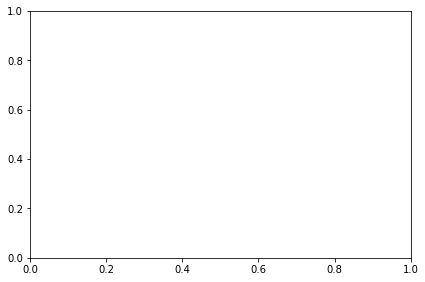

In [9]:
# Set up logging
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO

# Clear any existing handlers to avoid conflicts
logging.getLogger().handlers = []

# Set up logging with explicit console output
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',  # Include timestamp and level
    handlers=[
        logging.StreamHandler()  # Output to console
        # Optional: Add logging.FileHandler('imputation_analysis.log') to save to file
    ]
)

# --- Analyze the Imputed Datasets ---

# 1. Basic Info for Each Dataset
logging.info("Inspecting basic info for each imputed dataset:")
for i, df in enumerate(imputed_datasets):
    buffer = StringIO()
    df.info(buf=buffer)
    info_lines = buffer.getvalue().splitlines()
    log_message = f"Dataset {i} Info:\n" + "-"*20 + "\n" + "\n".join(info_lines)
    logging.info(log_message)
    logging.info(f"Dataset {i} Missing Values Total: {df.isnull().sum().sum()}")
    buffer.close()

# 2. Summarize Key Variables Across Datasets
key_vars = ['sex', 'race', 'V2116', 'V2105', 'V2166', 'V13', 'V2101', 'V2179', 'wave']
available_vars = [var for var in key_vars if var in imputed_datasets[0].columns]

logging.info(f"Analyzing key variables: {available_vars}")
summary_stats = {}
for var in available_vars:
    summary_stats[var] = []
    for i, df in enumerate(imputed_datasets):
        if df[var].dtype in ['int64', 'float64']:
            stats = df[var].describe()
            summary_stats[var].append(stats)
            logging.info(f"Dataset {i} - {var} Stats:\n{stats}")
        else:
            counts = df[var].value_counts(dropna=False)
            summary_stats[var].append(counts)
            logging.info(f"Dataset {i} - {var} Value Counts:\n{counts}")

# 3. Compare Variability Across Datasets
logging.info("Comparing variability across datasets for key variables:")
for var in available_vars:
    if imputed_datasets[0][var].dtype in ['int64', 'float64']:
        means = [df[var].mean() for df in imputed_datasets]
        stds = [df[var].std() for df in imputed_datasets]
        logging.info(f"{var} - Means across datasets: {means}")
        logging.info(f"{var} - Std Devs across datasets: {stds}")
    else:
        modes = [df[var].mode()[0] for df in imputed_datasets]
        logging.info(f"{var} - Most frequent value across datasets: {modes}")

# 4. Visualize Distributions
logging.info("Generating plots for key variables...")
plt.figure(figsize=(15, 10))
for j, var in enumerate(available_vars[:4]):  # Limit to first 4 for simplicity
    plt.subplot(2, 2, j+1)
    if imputed_datasets[0][var].dtype in ['int64', 'float64']:
        for i, df in enumerate(imputed_datasets):
            sns.kdeplot(df[var], label=f'Dataset {i}', alpha=0.5)
        plt.title(f"Distribution of {var}")
        plt.legend()
    else:
        counts = imputed_datasets[0][var].value_counts()
        counts.plot(kind='bar', title=f"{var} Counts (Dataset 0)")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'imputation_distributions.png'))
logging.info(f"Saved distribution plots to {os.path.join(output_dir, 'imputation_distributions.png')}")
plt.close()

In [43]:
from scipy.stats import norm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)

# Define output directory
output_dir = os.path.expanduser('~/work/vaping_project_data')
os.makedirs(output_dir, exist_ok=True)

# Assuming imputed_datasets is already loaded and contains the 5 imputed DataFrames
# Verify this assumption elsewhere in your script if needed

# Define the incremental predictors for each nested model
incremental_predictors = [
    ['wave', 'V2116', 'V2105', 'V2166', 'V13', 'V2101', 'V2179'],  # Model 1
    ['sex', 'race', 'V2184', 'V2164', 'V2108', 'V2194', 'V2173', 'V2191'],   # Add for Model 2
    ['V2152', 'V2176', 'V2196', 'V2195'],                  # Add for Model 3
    ['V2157', 'V2175'],                                              # Add for Model 4
    ['V2188', 'V2193', 'V2177'],                                                       # Add for Model 5
    ['V2187', 'V2182', 'V2153', 'V2137', 'V2185', 
     'V2183', 'V2172', 'V2128', 'V2143']                            # Add for Model 6
]

num_datasets = len(imputed_datasets)

# Function to combine results using Rubin's rules
def combine_mi_results(coeffs, ses, num_datasets):
    """
    Combine coefficients and standard errors from multiple imputations using Rubin's rules.
    
    Parameters:
    - coeffs: DataFrame of coefficients from each imputation (rows=imputations, cols=parameters)
    - ses: DataFrame of standard errors from each imputation (rows=imputations, cols=parameters)
    - num_datasets: Number of imputations
    
    Returns:
    - summary: DataFrame with combined estimates, standard errors, z-scores, and p-values
    """
    combined_coef = coeffs.mean(axis=0)
    within_var = (ses**2).mean(axis=0)
    between_var = coeffs.var(axis=0, ddof=1)
    total_var = within_var + (1 + 1/num_datasets) * between_var
    combined_se = np.sqrt(total_var)
    z = combined_coef / combined_se
    p_values = 2 * (1 - norm.cdf(np.abs(z)))
    summary = pd.DataFrame({
        'Coefficient': combined_coef,
        'Std. Error': combined_se,
        'z': z,
        'P>|z|': p_values
    })
    return summary

# --- Fit and Save Models ---
for k in range(1, 7):
    logging.info(f"Fitting Model {k}")
    
    # Build cumulative predictors for the current model
    predictors = sum(incremental_predictors[0:k], [])
    
    # Build formula, wrapping categorical variables with C()
    formula = "nicotine12d ~ " + " + ".join([
        "C(" + var + ")" if imputed_datasets[0][var].dtype == 'object' or 
        imputed_datasets[0][var].dtype.name == 'category' else var 
        for var in predictors
    ])
    
    fits = []
    for i, df in enumerate(imputed_datasets):
        logging.info(f"  Fitting on imputed dataset {i}")
        fit = smf.logit(formula, data=df).fit(disp=0)
        fits.append(fit)
    
    # Extract coefficients and standard errors
    coeffs = pd.concat([fit.params for fit in fits], axis=1).T
    ses = pd.concat([fit.bse for fit in fits], axis=1).T
    
    # Combine results using Rubin's rules
    summary = combine_mi_results(coeffs, ses, num_datasets)
    
    # Save summary to CSV
    output_filepath = os.path.join(output_dir, f'model_{k}_summary.csv')
    summary.to_csv(output_filepath, index=True)
    logging.info(f"Model {k} summary saved to {output_filepath}")



2025-02-24 22:37:42,662 - INFO - Fitting Model 1
2025-02-24 22:37:42,663 - INFO -   Fitting on imputed dataset 0
2025-02-24 22:37:42,831 - INFO -   Fitting on imputed dataset 1
2025-02-24 22:37:43,097 - INFO -   Fitting on imputed dataset 2
2025-02-24 22:37:43,273 - INFO -   Fitting on imputed dataset 3
2025-02-24 22:37:43,464 - INFO -   Fitting on imputed dataset 4
2025-02-24 22:37:43,700 - INFO - Model 1 summary saved to /storage/home/szn5432/work/vaping_project_data/model_1_summary.csv
2025-02-24 22:37:43,702 - INFO - Fitting Model 2
2025-02-24 22:37:43,704 - INFO -   Fitting on imputed dataset 0
2025-02-24 22:37:43,984 - INFO -   Fitting on imputed dataset 1
2025-02-24 22:37:44,230 - INFO -   Fitting on imputed dataset 2
2025-02-24 22:37:44,410 - INFO -   Fitting on imputed dataset 3
2025-02-24 22:37:44,563 - INFO -   Fitting on imputed dataset 4
2025-02-24 22:37:44,814 - INFO - Model 2 summary saved to /storage/home/szn5432/work/vaping_project_data/model_2_summary.csv
2025-02-24 2

In [47]:
# --- Examine the Results ---

# Load the summary results for each model
model_summaries = []
for k in range(1, 7):
    filepath = os.path.join(output_dir, f'model_{k}_summary.csv')
    try:
        summary = pd.read_csv(filepath, index_col=0)  # Index is parameter names
        summary['Model'] = f'Model {k}'
        model_summaries.append(summary)
        logging.info(f"Loaded summary for Model {k} from {filepath}")
    except FileNotFoundError:
        logging.error(f"File not found: {filepath}. Skipping.")
        continue

if not model_summaries:
    logging.error("No model summaries loaded. Exiting.")
    raise SystemExit

# Combine all summaries into one DataFrame
all_summaries = pd.concat(model_summaries, axis=0, ignore_index=False)

# 1. Display Summary for Each Model
logging.info("Summary of Results for Each Model:")
for k in range(1, 7):
    model_data = all_summaries[all_summaries['Model'] == f'Model {k}']
    logging.info(f"\nModel {k} Results:")
    logging.info(f"{'-'*40}")
    formatted_table = model_data.to_string(float_format="%.4f")
    logging.info(formatted_table)
    significant = model_data[model_data['P>|z|'] < 0.05]
    if not significant.empty:
        logging.info(f"Significant predictors (p < 0.05) in Model {k}:")
        logging.info(significant[['Coefficient', 'P>|z|']].to_string(float_format="%.4f"))

# 2. Compare Coefficients Across Models
logging.info("\nComparing Coefficients Across Models:")
predictors = all_summaries.index.unique()
for predictor in predictors:
    predictor_data = all_summaries[all_summaries.index == predictor]
    if not predictor_data.empty:
        logging.info(f"\nPredictor: {predictor}")
        logging.info(f"{'-'*20}")
        comparison = predictor_data[['Model', 'Coefficient', 'Std. Error', 'P>|z|']]
        logging.info(comparison.to_string(float_format="%.4f"))

# 3. Visualize Coefficients with Confidence Intervals
logging.info("\nGenerating coefficient plots...")
plt.figure(figsize=(15, 10))

# Select key predictors to visualize (main effects only, not all dummies)
key_predictors = [
    'Intercept', 'wave', 'V2116', 'V2105', 'V2166', 'V13', 'V2101', 'V2179', 
    'sex', 'race', 'V2184', 'V2164', 'V2108', 'V2194', 'V2173', 
    'V2152', 'V2191', 'V2176', 'V2196', 'V2195', 
    'V2157', 'V2175', 'V2177', 
    'V2187', 'V2188', 'V2182', 'V2153', 'V2137', 'V2185', 'V2183', 'V2172', 'V2128', 'V2143'
]
key_predictors = [p for p in key_predictors if p in all_summaries.index.unique()]

for i, predictor in enumerate(key_predictors[:6]):  # Limit to first 6 for readability
    plt.subplot(3, 2, i + 1)
    predictor_data = all_summaries[all_summaries.index == predictor]
    if not predictor_data.empty:
        lower_ci = predictor_data['Coefficient'] - 1.96 * predictor_data['Std. Error']
        upper_ci = predictor_data['Coefficient'] + 1.96 * predictor_data['Std. Error']
        
        plt.errorbar(
            predictor_data['Model'], predictor_data['Coefficient'], 
            yerr=[predictor_data['Coefficient'] - lower_ci, upper_ci - predictor_data['Coefficient']],
            fmt='o-', capsize=5, label=predictor
        )
        plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
        plt.title(f"Coefficient of {predictor} Across Models")
        plt.xlabel("Model")
        plt.ylabel("Coefficient")
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'coefficient_plots.png'))
logging.info(f"Saved coefficient plots to {os.path.join(output_dir, 'coefficient_plots.png')}")
plt.close()

2025-02-24 22:39:43,501 - INFO - Loaded summary for Model 1 from /storage/home/szn5432/work/vaping_project_data/model_1_summary.csv
2025-02-24 22:39:43,504 - INFO - Loaded summary for Model 2 from /storage/home/szn5432/work/vaping_project_data/model_2_summary.csv
2025-02-24 22:39:43,509 - INFO - Loaded summary for Model 3 from /storage/home/szn5432/work/vaping_project_data/model_3_summary.csv
2025-02-24 22:39:43,513 - INFO - Loaded summary for Model 4 from /storage/home/szn5432/work/vaping_project_data/model_4_summary.csv
2025-02-24 22:39:43,516 - INFO - Loaded summary for Model 5 from /storage/home/szn5432/work/vaping_project_data/model_5_summary.csv
2025-02-24 22:39:43,519 - INFO - Loaded summary for Model 6 from /storage/home/szn5432/work/vaping_project_data/model_6_summary.csv
2025-02-24 22:39:43,521 - INFO - Summary of Results for Each Model:
2025-02-24 22:39:43,522 - INFO - 
Model 1 Results:
2025-02-24 22:39:43,522 - INFO - ----------------------------------------
2025-02-24 22:3

In [49]:
from scipy.stats import chi2

# Fit null model once for Pseudo-R²
null_fits = [smf.logit("nicotine12d ~ 1", data=df).fit(disp=0) for df in imputed_datasets]
null_llf = np.mean([fit.llf for fit in null_fits])

# --- Fit and Store Models for LR Tests ---
all_fits = {}
for k in range(1, 7):
    logging.info(f"Fitting Model {k}")
    predictors = sum(incremental_predictors[0:k], [])
    formula = "nicotine12d ~ " + " + ".join([
        "C(" + var + ")" if imputed_datasets[0][var].dtype == 'object' or 
        imputed_datasets[0][var].dtype.name == 'category' else var 
        for var in predictors
    ])
    
    fits = []
    for i, df in enumerate(imputed_datasets):
        logging.info(f"  Fitting on imputed dataset {i}")
        fit = smf.logit(formula, data=df).fit(disp=0)
        fits.append(fit)
    
    all_fits[f'Model {k}'] = fits
    
    # Compute AIC, BIC, and Pseudo-R²
    aic_values = [-2 * fit.llf + 2 * len(fit.params) for fit in fits]
    bic_values = [-2 * fit.llf + np.log(len(imputed_datasets[0])) * len(fit.params) for fit in fits]
    r2_values = [1 - (fit.llf / null_llf) for fit in fits]
    logging.info(f"Model {k} - Avg AIC: {np.mean(aic_values):.4f}, Avg BIC: {np.mean(bic_values):.4f}, Avg McFadden’s R²: {np.mean(r2_values):.4f}")

# --- Perform LR Tests ---
def lr_test_mi(reduced_fits, full_fits, df_diff, num_datasets):
    lr_stats = [2 * (f_fit.llf - r_fit.llf) for r_fit, f_fit in zip(reduced_fits, full_fits)]
    combined_lr_stat = np.mean(lr_stats)
    p_value = chi2.sf(combined_lr_stat, df_diff)
    return combined_lr_stat, p_value

logging.info("\nPerforming Likelihood Ratio Tests Between Nested Models:")
lr_results = []
for k in range(2, 7):
    reduced_model = f'Model {k-1}'
    full_model = f'Model {k}'
    new_predictors = incremental_predictors[k-1]
    df_diff = sum(len(imputed_datasets[0][var].unique()) - 1 if imputed_datasets[0][var].dtype == 'object' or 
                  imputed_datasets[0][var].dtype.name == 'category' else 1 for var in new_predictors)
    
    lr_stat, p_value = lr_test_mi(all_fits[reduced_model], all_fits[full_model], df_diff, num_datasets)
    lr_results.append({
        'Comparison': f'{reduced_model} vs. {full_model}',
        'LR Statistic': lr_stat,
        'Degrees of Freedom': df_diff,
        'P-value': p_value
    })
    logging.info(f"{reduced_model} vs. {full_model}:")
    logging.info(f"  LR Statistic: {lr_stat:.4f}")
    logging.info(f"  Degrees of Freedom: {df_diff}")
    logging.info(f"  P-value: {p_value:.4f}")

lr_df = pd.DataFrame(lr_results)
lr_df.to_csv(os.path.join(output_dir, 'lr_test_results.csv'), index=False)
logging.info(f"LR test results saved to {os.path.join(output_dir, 'lr_test_results.csv')}")

2025-02-24 22:57:18,545 - INFO - Fitting Model 1
2025-02-24 22:57:18,547 - INFO -   Fitting on imputed dataset 0
2025-02-24 22:57:18,654 - INFO -   Fitting on imputed dataset 1
2025-02-24 22:57:18,759 - INFO -   Fitting on imputed dataset 2
2025-02-24 22:57:18,865 - INFO -   Fitting on imputed dataset 3
2025-02-24 22:57:18,971 - INFO -   Fitting on imputed dataset 4
2025-02-24 22:57:19,098 - INFO - Model 1 - Avg AIC: 94290.8926, Avg BIC: 94364.3359, Avg McFadden’s R²: 0.0426
2025-02-24 22:57:19,100 - INFO - Fitting Model 2
2025-02-24 22:57:19,102 - INFO -   Fitting on imputed dataset 0
2025-02-24 22:57:19,355 - INFO -   Fitting on imputed dataset 1
2025-02-24 22:57:19,602 - INFO -   Fitting on imputed dataset 2
2025-02-24 22:57:19,771 - INFO -   Fitting on imputed dataset 3
2025-02-24 22:57:19,924 - INFO -   Fitting on imputed dataset 4
2025-02-24 22:57:20,225 - INFO - Model 2 - Avg AIC: 94243.8073, Avg BIC: 94381.5135, Avg McFadden’s R²: 0.0432
2025-02-24 22:57:20,227 - INFO - Fitting

2025-02-27 20:30:43,929 - INFO - Loaded imputed dataset 0 from /storage/home/szn5432/work/vaping_project_data/imputed_merged_data_g12_0.csv
2025-02-27 20:30:44,652 - INFO - Loaded imputed dataset 1 from /storage/home/szn5432/work/vaping_project_data/imputed_merged_data_g12_1.csv
2025-02-27 20:30:45,376 - INFO - Loaded imputed dataset 2 from /storage/home/szn5432/work/vaping_project_data/imputed_merged_data_g12_2.csv
2025-02-27 20:30:46,104 - INFO - Loaded imputed dataset 3 from /storage/home/szn5432/work/vaping_project_data/imputed_merged_data_g12_3.csv
2025-02-27 20:30:46,830 - INFO - Loaded imputed dataset 4 from /storage/home/szn5432/work/vaping_project_data/imputed_merged_data_g12_4.csv
2025-02-27 20:30:46,835 - INFO - Running Model 1 with 7 predictors
2025-02-27 20:30:46,835 - INFO - Processing dataset 0 for Model 1
2025-02-27 20:30:51,052 - INFO - Model Model 1 on dataset 0 - ROC AUC: 0.6251, Pseudo R²: 0.0426
2025-02-27 20:30:51,053 - INFO - Processing dataset 1 for Model 1
2025

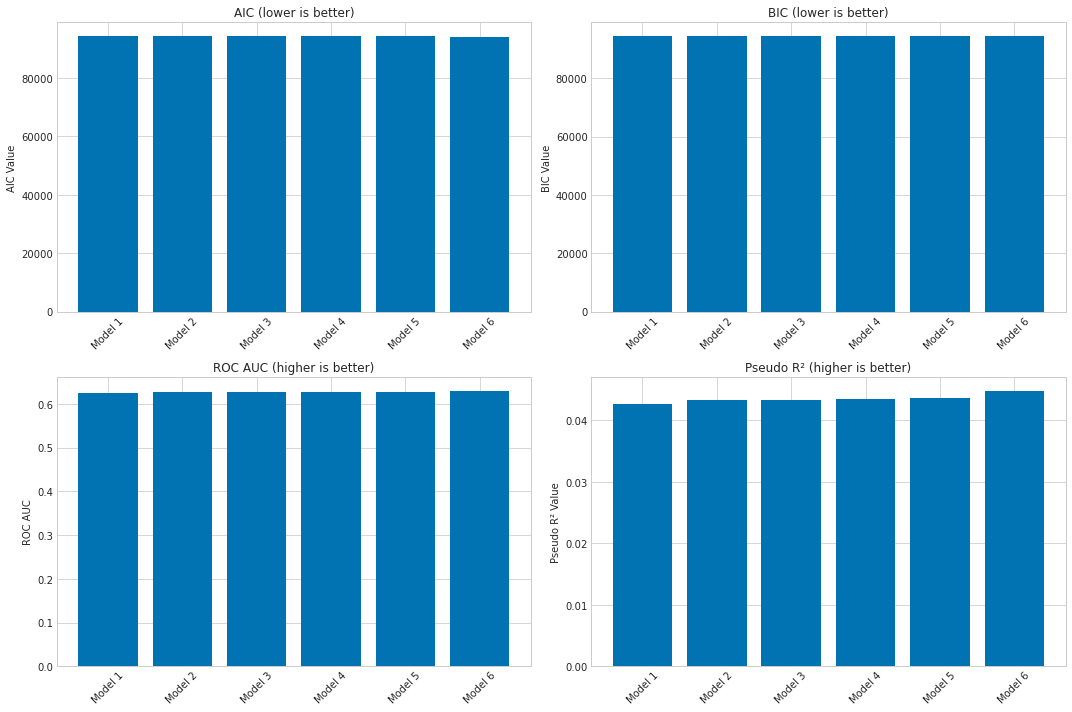

<Figure size 720x432 with 0 Axes>

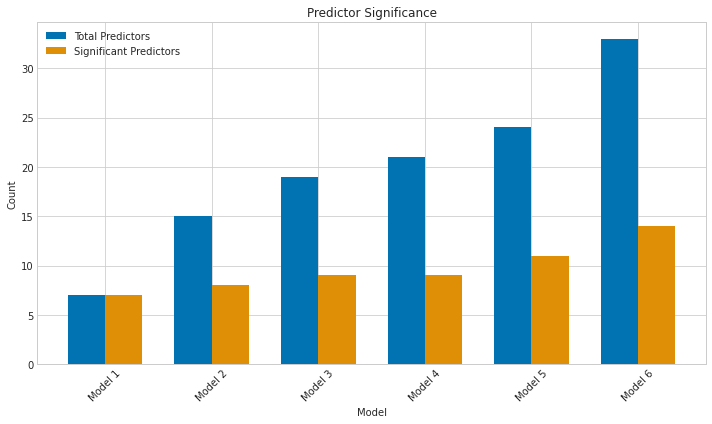

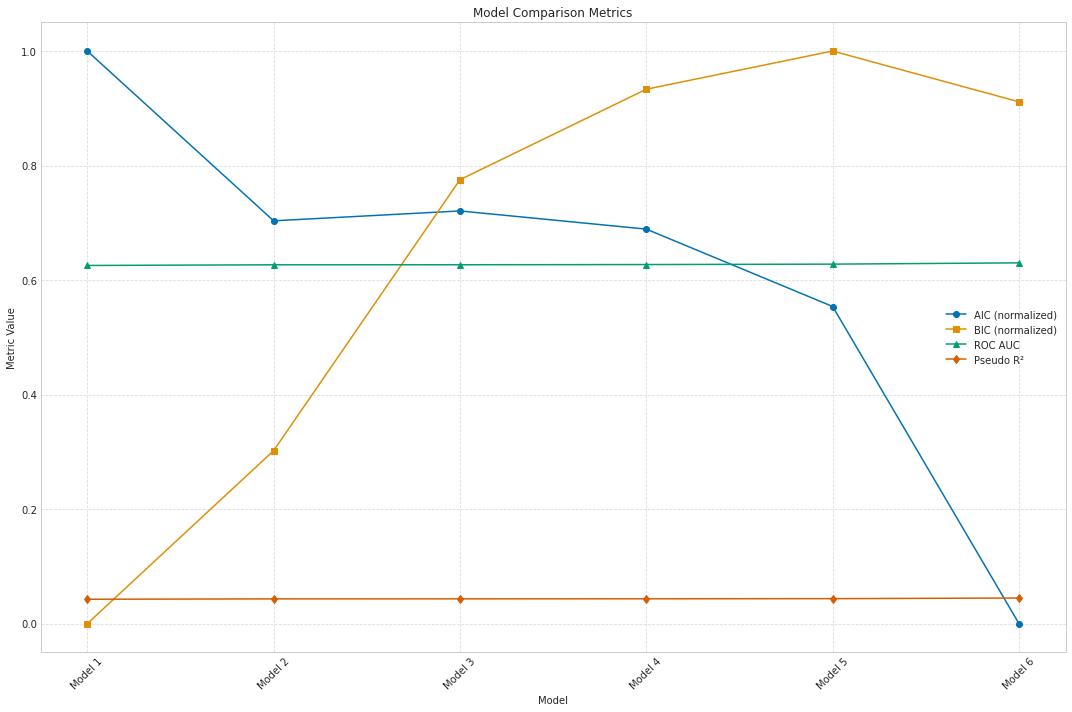

In [21]:
import pandas as pd
import numpy as np
import os
import logging
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler('nested_models_analysis.log')
    ]
)

# Define the nested model variable sets based on the frequency across the 6 models
model_variables = {
    'Model 1': ['wave', 'V2116', 'V2105', 'V2166', 'V13', 'V2101', 'V2179'],
    'Model 2': ['wave', 'V2116', 'V2105', 'V2166', 'V13', 'V2101', 'V2179', 
                'sex', 'V2184', 'race', 'V2108', 'V2194', 'V2191', 'V2173', 'V2164'],
    'Model 3': ['wave', 'V2116', 'V2105', 'V2166', 'V13', 'V2101', 'V2179', 
                'sex', 'V2184', 'race', 'V2108', 'V2194', 'V2191', 'V2173', 'V2164',
                'V2195', 'V2152', 'V2176', 'V2196'],
    'Model 4': ['wave', 'V2116', 'V2105', 'V2166', 'V13', 'V2101', 'V2179', 
                'sex', 'V2184', 'race', 'V2108', 'V2194', 'V2191', 'V2173', 'V2164',
                'V2195', 'V2152', 'V2176', 'V2196',
                'V2157', 'V2175'],
    'Model 5': ['wave', 'V2116', 'V2105', 'V2166', 'V13', 'V2101', 'V2179', 
                'sex', 'V2184', 'race', 'V2108', 'V2194', 'V2191', 'V2173', 'V2164',
                'V2195', 'V2152', 'V2176', 'V2196',
                'V2157', 'V2175',
                'V2188', 'V2193', 'V2177'],
    'Model 6': ['wave', 'V2116', 'V2105', 'V2166', 'V13', 'V2101', 'V2179', 
                'sex', 'V2184', 'race', 'V2108', 'V2194', 'V2191', 'V2173', 'V2164',
                'V2195', 'V2152', 'V2176', 'V2196',
                'V2157', 'V2175',
                'V2188', 'V2193', 'V2177',
                'V2182', 'V2187', 'V2153', 'V2137', 'V2185', 'V2183', 'V2172', 'V2128', 'V2143']
}

# Define the dependent variable
dependent_var = 'nicotine12d'

def run_logistic_regression(X, y, max_iter=1000):
    """Run logistic regression and return results."""
    try:
        # Standardize the features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Fit the model
        logit_model = LogisticRegression(max_iter=max_iter, solver='lbfgs', random_state=42)
        logit_model.fit(X_scaled, y)
        
        # Get predictions
        y_pred_proba = logit_model.predict_proba(X_scaled)[:, 1]
        y_pred = logit_model.predict(X_scaled)
        
        # Calculate metrics
        ll = log_loss(y, y_pred_proba)
        roc_auc = roc_auc_score(y, y_pred_proba)
        
        # Pseudo R² (McFadden's)
        null_model = LogisticRegression(max_iter=max_iter, solver='lbfgs', random_state=42)
        null_model.fit(np.ones((X.shape[0], 1)), y)
        null_proba = null_model.predict_proba(np.ones((X.shape[0], 1)))[:, 1]
        null_ll = log_loss(y, null_proba)
        pseudo_r2 = 1 - (ll / null_ll)
        
        # Calculate standard errors using bootstrap
        n_bootstraps = 100
        coefs_bootstrap = []
        for i in range(n_bootstraps):
            # Randomly sample with replacement
            idx = np.random.choice(X.shape[0], X.shape[0], replace=True)
            X_boot, y_boot = X_scaled[idx], y.iloc[idx] if hasattr(y, 'iloc') else y[idx]
            
            boot_model = LogisticRegression(max_iter=max_iter, solver='lbfgs', random_state=i)
            boot_model.fit(X_boot, y_boot)
            coefs_bootstrap.append(boot_model.coef_[0])
        
        # Calculate standard errors from bootstrap distributions
        bootstrap_std_errs = np.std(coefs_bootstrap, axis=0)
        
        result = {
            'model': logit_model,
            'coef': logit_model.coef_[0],
            'intercept': logit_model.intercept_[0],
            'feature_names': X.columns.tolist(),
            'bse': bootstrap_std_errs,
            'log_loss': ll,
            'roc_auc': roc_auc,
            'pseudo_r2': pseudo_r2,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }
        
        return result
    except Exception as e:
        logging.error(f"Error in logistic regression: {str(e)}")
        return None

def pool_results_using_rubins_rules(results):
    """
    Pool results from multiple imputations using Rubin's Rules.
    
    Parameters:
    results (list): List of dictionaries with model results
    
    Returns:
    dict: Dictionary with pooled coefficients, standard errors, etc.
    """
    if not results or len(results) == 0:
        return None
    
    # Get feature names from the first result
    feature_names = results[0]['feature_names']
    m = len(results)  # Number of imputations
    
    # Step 1: Calculate the mean of the coefficients across imputations
    intercepts = np.array([r['intercept'] for r in results])
    pooled_intercept = np.mean(intercepts)
    
    coefs = np.array([r['coef'] for r in results])
    pooled_coefs = np.mean(coefs, axis=0)
    
    # Step 2: Calculate within-imputation variance
    bses = np.array([r['bse'] for r in results])
    within_var = np.mean(np.square(bses), axis=0)
    
    # Step 3: Calculate between-imputation variance
    between_var_coefs = np.var(coefs, axis=0, ddof=1)
    
    # Step 4: Calculate total variance
    total_var = within_var + between_var_coefs * (1 + 1/m)
    pooled_std_errs = np.sqrt(total_var)
    
    # Calculate pooled z-statistics and p-values
    z_stats = pooled_coefs / pooled_std_errs
    p_values = 2 * (1 - norm.cdf(abs(z_stats)))
    
    # Calculate 95% confidence intervals
    lower_ci = pooled_coefs - 1.96 * pooled_std_errs
    upper_ci = pooled_coefs + 1.96 * pooled_std_errs
    
    # Pool goodness-of-fit metrics
    avg_log_loss = np.mean([r['log_loss'] for r in results])
    avg_roc_auc = np.mean([r['roc_auc'] for r in results])
    avg_pseudo_r2 = np.mean([r['pseudo_r2'] for r in results])
    
    # Calculate AIC and BIC manually
    # AIC = 2k - 2ln(L), where k is the number of parameters and L is the likelihood
    # For logistic regression, the log-likelihood can be related to log_loss
    n_samples = len(results[0]['y_pred'])  # Number of samples
    n_features = len(feature_names)  # Number of features
    
    # log_loss = -log_likelihood / n_samples
    # So log_likelihood = -n_samples * log_loss
    avg_log_likelihood = -n_samples * avg_log_loss
    
    # AIC and BIC (add 1 for intercept)
    aic = 2 * (n_features + 1) - 2 * avg_log_likelihood
    bic = (n_features + 1) * np.log(n_samples) - 2 * avg_log_likelihood
    
    # Return pooled results in a dictionary with feature names as keys
    params = pd.Series(pooled_coefs, index=feature_names)
    bse = pd.Series(pooled_std_errs, index=feature_names)
    pvalues = pd.Series(p_values, index=feature_names)
    conf_int = pd.DataFrame(
        np.column_stack([lower_ci, upper_ci]), 
        index=feature_names,
        columns=['lower', 'upper']
    )
    
    return {
        'params': params,
        'intercept': pooled_intercept,
        'bse': bse,
        'pvalues': pvalues,
        'conf_int': conf_int,
        'aic': aic,
        'bic': bic,
        'log_loss': avg_log_loss,
        'roc_auc': avg_roc_auc,
        'prsquared': avg_pseudo_r2
    }

def create_summary_table(all_models_results):
    """Create a summary table comparing all models."""
    summary_data = []
    for model_name, result in all_models_results.items():
        # Count significant predictors
        sig_predictors = sum(result['pvalues'] < 0.05)
        total_predictors = len(result['params'])
        
        summary_data.append({
            'Model': model_name,
            'Num Predictors': total_predictors,
            'AIC': result['aic'],
            'BIC': result['bic'],
            'Log-Loss': result['log_loss'],
            'ROC AUC': result['roc_auc'],
            'Pseudo R²': result['prsquared'],
            'Significant Predictors': sig_predictors
        })
    
    return pd.DataFrame(summary_data)

def identify_key_predictors(all_models_results):
    """
    Identify key predictors across all models based on effect sizes.
    
    Parameters:
    all_models_results (dict): Dictionary with results for all models
    
    Returns:
    pd.DataFrame: DataFrame with most impactful predictors across models
    """
    key_predictors_data = []
    
    for model_name, result in all_models_results.items():
        params = result['params']
        pvalues = result['pvalues']
        significant = pvalues < 0.05
        
        # Get top 5 significant predictors by absolute coefficient size
        top_predictors = params[significant].abs().sort_values(ascending=False).head(5)
        
        for predictor, effect_size in top_predictors.items():
            key_predictors_data.append({
                'Model': model_name,
                'Predictor': predictor,
                'Coefficient': params[predictor],
                'p-value': pvalues[predictor],
                'Odds Ratio': np.exp(params[predictor])
            })
    
    # Create DataFrame and sort by absolute coefficient value
    key_predictors_df = pd.DataFrame(key_predictors_data)
    if not key_predictors_df.empty:
        key_predictors_df = key_predictors_df.sort_values(['Model', 'p-value'])
    
    return key_predictors_df

def main():
    # Load the datasets
    output_dir = os.path.expanduser('~/work/vaping_project_data')
    base_filename = 'imputed_merged_data_g12'
    num_datasets = 5  # 5 imputed datasets

    # Load the imputed datasets
    imputed_datasets = []
    for i in range(num_datasets):
        filepath = os.path.join(output_dir, f'{base_filename}_{i}.csv')
        try:
            df = pd.read_csv(filepath)
            imputed_datasets.append(df)
            logging.info(f"Loaded imputed dataset {i} from {filepath}")
        except FileNotFoundError:
            logging.error(f"File not found: {filepath}. Skipping.")
            continue

    if not imputed_datasets:
        logging.error("No imputed datasets loaded. Exiting.")
        raise SystemExit

    # Check if the dependent variable exists in the datasets
    for i, df in enumerate(imputed_datasets):
        if dependent_var not in df.columns:
            logging.error(f"Dependent variable '{dependent_var}' not found in dataset {i}. Exiting.")
            raise SystemExit
        
        # Verify the dependent variable is binary (0 or 1)
        unique_values = df[dependent_var].unique()
        if not set(unique_values).issubset({0, 1}):
            logging.warning(f"Dependent variable in dataset {i} is not binary: {unique_values}")
            
            # If not binary, attempt to convert it to binary
            if len(unique_values) == 2:
                # If we have exactly two values, map the lower one to 0 and the higher one to 1
                logging.info(f"Converting {dependent_var} to binary 0/1 encoding")
                min_val, max_val = min(unique_values), max(unique_values)
                df[dependent_var] = df[dependent_var].map({min_val: 0, max_val: 1})
            else:
                logging.error(f"Cannot convert {dependent_var} to binary. Model may not work correctly.")

    # Run models and pool results
    all_models_results = {}

    for model_name, predictors in model_variables.items():
        logging.info(f"Running {model_name} with {len(predictors)} predictors")
        
        # Check if all predictors exist in the datasets
        missing_predictors = []
        for predictor in predictors:
            if predictor not in imputed_datasets[0].columns:
                missing_predictors.append(predictor)
        
        if missing_predictors:
            logging.warning(f"Missing predictors in {model_name}: {missing_predictors}")
            # Remove missing predictors from the list
            predictors = [p for p in predictors if p in imputed_datasets[0].columns]
            logging.info(f"Proceeding with {len(predictors)} available predictors")
        
        # Run the model on each imputed dataset
        model_results = []
        for i, df in enumerate(imputed_datasets):
            logging.info(f"Processing dataset {i} for {model_name}")
            
            try:
                # Prepare data
                X = df[predictors]
                y = df[dependent_var]
                
                # Run logistic regression
                result = run_logistic_regression(X, y)
                if result:
                    model_results.append(result)
                    logging.info(f"Model {model_name} on dataset {i} - ROC AUC: {result['roc_auc']:.4f}, Pseudo R²: {result['pseudo_r2']:.4f}")
            except Exception as e:
                logging.error(f"Error processing dataset {i} for {model_name}: {str(e)}")
                continue
        
        # Pool results if we have multiple successful models
        if len(model_results) > 1:  # Need at least 2 for pooling with Rubin's Rules
            pooled_results = pool_results_using_rubins_rules(model_results)
            if pooled_results:
                all_models_results[model_name] = pooled_results
                logging.info(f"Successfully pooled results for {model_name}")
            else:
                logging.warning(f"Failed to pool results for {model_name}")
        elif len(model_results) == 1:
            # If we only have one result, create a similar structure to pooled results
            result = model_results[0]
            params = pd.Series(result['coef'], index=result['feature_names'])
            bse = pd.Series(result['bse'], index=result['feature_names'])
            z_stats = params / bse
            p_values = 2 * (1 - norm.cdf(abs(z_stats)))
            
            n_samples = len(result['y_pred'])
            n_features = len(result['feature_names'])
            
            log_likelihood = -n_samples * result['log_loss']
            aic = 2 * (n_features + 1) - 2 * log_likelihood
            bic = (n_features + 1) * np.log(n_samples) - 2 * log_likelihood
            
            all_models_results[model_name] = {
                'params': params,
                'intercept': result['intercept'],
                'bse': bse,
                'pvalues': p_values,
                'conf_int': pd.DataFrame({
                    'lower': params - 1.96 * bse,
                    'upper': params + 1.96 * bse
                }),
                'aic': aic,
                'bic': bic,
                'log_loss': result['log_loss'],
                'roc_auc': result['roc_auc'],
                'prsquared': result['pseudo_r2']
            }
            logging.warning(f"Only one successful model for {model_name} - not pooling results")
        else:
            logging.warning(f"No results to pool for {model_name}")

    # Create summary table
    if all_models_results:
        summary_df = create_summary_table(all_models_results)
        logging.info("Model Comparison Summary:")
        logging.info("\n" + summary_df.to_string())
        
        # Save summary to CSV
        summary_df.to_csv('model_comparison_summary.csv', index=False)
        
        # Create detailed results tables for each model
        for model_name, result in all_models_results.items():
            # Calculate odds ratios and their confidence intervals
            odds_ratios = np.exp(result['params'])
            odds_ratio_lower = np.exp(result['conf_int']['lower'])
            odds_ratio_upper = np.exp(result['conf_int']['upper'])
            
            detailed_results = pd.DataFrame({
                'Predictor': result['params'].index,
                'Coefficient': result['params'].values,
                'Std.Error': result['bse'].values,
                'p-value': result['pvalues'].values,
                'Odds Ratio': odds_ratios.values,
                'OR 95% CI Lower': odds_ratio_lower.values,
                'OR 95% CI Upper': odds_ratio_upper.values
            })
            
            # Sort by p-value for easier interpretation
            detailed_results = detailed_results.sort_values('p-value')
            
            # Save to CSV
            output_filename = f"{model_name.replace(' ', '_')}_results.csv"
            detailed_results.to_csv(output_filename, index=False)
            logging.info(f"Saved detailed results for {model_name} to {output_filename}")
        
        # Identify key predictors
        key_predictors = identify_key_predictors(all_models_results)
        if not key_predictors.empty:
            logging.info("Key Predictors Across Models:")
            logging.info("\n" + key_predictors.to_string())
            
            # Save key predictors to CSV
            key_predictors.to_csv('key_predictors.csv', index=False)
            logging.info("Saved key predictors to 'key_predictors.csv'")
        
        # Create visualizations for model comparison
        plt.figure(figsize=(15, 10))
        
        # Create sorted version of summary dataframe for consistent plotting
        summary_df_sorted = summary_df.sort_values('Model')
        
        # Plot AIC using matplotlib instead of seaborn
        plt.subplot(2, 2, 1)
        model_names = summary_df_sorted['Model'].to_numpy()
        model_indices = np.arange(len(model_names))
        plt.bar(model_indices, summary_df_sorted['AIC'].to_numpy())
        plt.title('AIC (lower is better)')
        plt.xticks(model_indices, model_names, rotation=45)
        plt.ylabel('AIC Value')
        
        # Plot BIC
        plt.subplot(2, 2, 2)
        plt.bar(model_indices, summary_df_sorted['BIC'].to_numpy())
        plt.title('BIC (lower is better)')
        plt.xticks(model_indices, model_names, rotation=45)
        plt.ylabel('BIC Value')
        
        # Plot ROC AUC
        plt.subplot(2, 2, 3)
        plt.bar(model_indices, summary_df_sorted['ROC AUC'].to_numpy())
        plt.title('ROC AUC (higher is better)')
        plt.xticks(model_indices, model_names, rotation=45)
        plt.ylabel('ROC AUC')
        
        # Plot Pseudo R²
        plt.subplot(2, 2, 4)
        plt.bar(model_indices, summary_df_sorted['Pseudo R²'].to_numpy())
        plt.title('Pseudo R² (higher is better)')
        plt.xticks(model_indices, model_names, rotation=45)
        plt.ylabel('Pseudo R² Value')
        
        plt.tight_layout()
        plt.savefig('model_metrics.png', dpi=300)
        
        # Plot Number of Significant Predictors vs. Total Predictors
        plt.figure(figsize=(10, 6))
        
        # Set up the bar positions
        model_names = summary_df_sorted['Model'].to_numpy()
        x = np.arange(len(model_names))
        width = 0.35
        
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.bar(x - width/2, summary_df_sorted['Num Predictors'].to_numpy(), width, label='Total Predictors')
        ax.bar(x + width/2, summary_df_sorted['Significant Predictors'].to_numpy(), width, label='Significant Predictors')
        
        ax.set_title('Predictor Significance')
        ax.set_xlabel('Model')
        ax.set_ylabel('Count')
        ax.set_xticks(x)
        ax.set_xticklabels(model_names, rotation=45)
        ax.legend()
        
        plt.tight_layout()
        plt.savefig('predictor_significance.png', dpi=300)
        
        # Create a model comparison visualization
        plt.figure(figsize=(15, 10))
        
        # Create a line plot for AIC, BIC, ROC AUC, and R²
        plt.subplot(1, 1, 1)
        
        # Convert to numpy arrays to avoid pandas indexing issues
        model_names = summary_df_sorted['Model'].to_numpy()
        model_indices = np.arange(len(model_names))
        
        # Normalize values to be on the same scale
        aic_values = summary_df_sorted['AIC'].to_numpy()
        aic_norm = (aic_values - np.min(aic_values)) / (np.max(aic_values) - np.min(aic_values))
        
        bic_values = summary_df_sorted['BIC'].to_numpy()
        bic_norm = (bic_values - np.min(bic_values)) / (np.max(bic_values) - np.min(bic_values))
        
        roc_auc = summary_df_sorted['ROC AUC'].to_numpy()  # No need to normalize, already between 0-1
        rsq_norm = summary_df_sorted['Pseudo R²'].to_numpy()  # Already normalized
        
        plt.plot(model_indices, aic_norm, marker='o', label='AIC (normalized)')
        plt.plot(model_indices, bic_norm, marker='s', label='BIC (normalized)')
        plt.plot(model_indices, roc_auc, marker='^', label='ROC AUC')
        plt.plot(model_indices, rsq_norm, marker='d', label='Pseudo R²')
        
        plt.title('Model Comparison Metrics')
        plt.xlabel('Model')
        plt.xticks(model_indices, model_names, rotation=45)
        plt.ylabel('Metric Value')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.savefig('model_comparison.png', dpi=300)
        
        # Find best models
        best_aic_model = summary_df.loc[summary_df['AIC'].idxmin()]
        best_roc_model = summary_df.loc[summary_df['ROC AUC'].idxmax()]
        
        logging.info(f"\nBased on AIC, the best model is {best_aic_model['Model']} with AIC={best_aic_model['AIC']:.2f}")
        logging.info(f"Based on ROC AUC, the best model is {best_roc_model['Model']} with ROC AUC={best_roc_model['ROC AUC']:.4f}")
    else:
        logging.error("No models were successfully run. Cannot create summary.")

    logging.info("Analysis complete.")

if __name__ == "__main__":
    main()

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from matplotlib.colors import LinearSegmentedColormap

# Set the style for the plots - use a more universally available style
try:
    plt.style.use('seaborn-whitegrid')  # For older matplotlib
except:
    try:
        plt.style.use('seaborn-v0_8-whitegrid')  # For newer matplotlib
    except:
        # Fall back to default style if neither is available
        pass

# Set a colorblind-friendly palette
try:
    sns.set_palette("colorblind")
except:
    pass  # Continue without custom palette if there's an issue

def load_model_results():
    """Load all model results from CSV files."""
    # Find all model result files
    model_files = glob.glob("Model_*_results.csv")
    
    if not model_files:
        print("No model result files found. Make sure you've run the main analysis first.")
        return None
    
    # Load summary comparison file
    try:
        summary_df = pd.read_csv("model_comparison_summary.csv")
        print(f"Loaded model comparison summary with {len(summary_df)} models.")
    except FileNotFoundError:
        print("Model comparison summary file not found.")
        summary_df = None
    
    # Load individual model results
    model_results = {}
    for file in sorted(model_files):
        model_name = file.replace("_results.csv", "").replace("_", " ")
        df = pd.read_csv(file)
        model_results[model_name] = df
        print(f"Loaded {model_name} with {len(df)} predictors.")
    
    # Load key predictors if available
    try:
        key_predictors = pd.read_csv("key_predictors.csv")
        print(f"Loaded key predictors data with {len(key_predictors)} entries.")
    except FileNotFoundError:
        print("Key predictors file not found.")
        key_predictors = None
        
    return {
        'summary': summary_df,
        'models': model_results,
        'key_predictors': key_predictors
    }

def plot_model_summary(summary_df):
    """Create an overall summary plot of model performance."""
    if summary_df is None:
        print("No summary data available.")
        return
    
    plt.figure(figsize=(14, 10))
    
    # Sort by model number
    summary_df = summary_df.copy()
    summary_df['Model_Num'] = summary_df['Model'].str.extract(r'Model (\d+)').astype(int)
    summary_df = summary_df.sort_values('Model_Num')
    
    # Convert to arrays for plotting
    models = summary_df['Model'].to_numpy()
    x = np.arange(len(models))
    
    # Create a 2x2 grid of metrics
    plt.subplot(2, 2, 1)
    plt.bar(x, summary_df['Pseudo R²'].to_numpy(), color='darkblue')
    plt.title('Pseudo R² by Model', fontsize=14)
    plt.xticks(x, models, rotation=45)
    plt.ylabel('Pseudo R²')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.subplot(2, 2, 2)
    plt.bar(x, summary_df['ROC AUC'].to_numpy(), color='darkgreen')
    plt.title('ROC AUC by Model', fontsize=14)
    plt.xticks(x, models, rotation=45)
    plt.ylabel('ROC AUC')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.subplot(2, 2, 3)
    plt.bar(x, summary_df['AIC'].to_numpy(), color='darkred')
    plt.title('AIC by Model (Lower is Better)', fontsize=14)
    plt.xticks(x, models, rotation=45)
    plt.ylabel('AIC')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.subplot(2, 2, 4)
    
    # Efficiency plot: ratio of significant predictors to total predictors
    efficiency = summary_df['Significant Predictors'] / summary_df['Num Predictors']
    plt.bar(x, efficiency.to_numpy(), color='purple')
    plt.title('Model Efficiency (Sig. Predictors / Total)', fontsize=14)
    plt.xticks(x, models, rotation=45)
    plt.ylabel('Efficiency Ratio')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('model_performance_summary.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Create a trade-off plot
    plt.figure(figsize=(10, 8))
    
    plt.scatter(summary_df['Num Predictors'], summary_df['ROC AUC'], 
                s=100, alpha=0.7, c=summary_df['Model_Num'], cmap='viridis')
    
    # Add model labels
    for i, model in enumerate(summary_df['Model']):
        plt.annotate(model, 
                     (summary_df['Num Predictors'].iloc[i], summary_df['ROC AUC'].iloc[i]),
                     xytext=(5, 5), textcoords='offset points')
    
    plt.title('Model Complexity vs. Performance', fontsize=16)
    plt.xlabel('Number of Predictors', fontsize=14)
    plt.ylabel('ROC AUC', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.colorbar(label='Model Number')
    
    plt.tight_layout()
    plt.savefig('model_complexity_tradeoff.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print("Model summary plots saved.")

def plot_coefficient_summary(model_results):
    """Plot coefficient summaries for each model."""
    if not model_results:
        print("No model results available.")
        return
    
    for model_name, df in model_results.items():
        # Sort by significance level (p-value)
        df_sorted = df.sort_values('p-value')
        
        # Select top 15 predictors by significance
        top_df = df_sorted.head(15)
        
        # Create a range of colors from red to blue
        cmap = plt.cm.RdBu_r
        
        plt.figure(figsize=(12, 8))
        
        # Plot coefficients
        bars = plt.barh(np.arange(len(top_df)), top_df['Coefficient'].to_numpy(), 
                         color=[cmap(p) for p in np.minimum(top_df['p-value'] * 10, 1.0)])
        
        # Add error bars
        error_bars = []
        for i, row in top_df.iterrows():
            lower = row['Coefficient'] - 1.96 * row['Std.Error']
            upper = row['Coefficient'] + 1.96 * row['Std.Error']
            error_bars.append((lower, upper))
        
        # Convert to numpy arrays for plotting
        error_lows = np.array([eb[0] for eb in error_bars])
        error_highs = np.array([eb[1] for eb in error_bars])
        
        # Use numpy arrays instead of pandas objects for matplotlib
        coef_values = top_df['Coefficient'].to_numpy()
        y_positions = np.arange(len(top_df))
        
        plt.errorbar(coef_values, y_positions, 
                     xerr=np.vstack([coef_values - error_lows, error_highs - coef_values]),
                     fmt='none', ecolor='black', capsize=3)
        
        # Set the y-tick labels manually
        plt.yticks(y_positions, top_df['Predictor'])
        
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.7)
        plt.title(f'Top 15 Predictors for {model_name}', fontsize=16)
        plt.xlabel('Coefficient Value', fontsize=14)
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        
        # Add p-value indicators
        for i, pvalue in enumerate(top_df['p-value']):
            if pvalue < 0.001:
                plt.text(max(top_df['Coefficient']) * 1.1, i, '***', ha='left', va='center')
            elif pvalue < 0.01:
                plt.text(max(top_df['Coefficient']) * 1.1, i, '**', ha='left', va='center')
            elif pvalue < 0.05:
                plt.text(max(top_df['Coefficient']) * 1.1, i, '*', ha='left', va='center')
        
        plt.tight_layout()
        filename = f"{model_name.replace(' ', '_')}_coefficients.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.close()
    
    print("Coefficient summary plots saved for each model.")

def plot_odds_ratio_summary(model_results):
    """Plot odds ratio summaries for each model."""
    if not model_results:
        print("No model results available.")
        return
    
    for model_name, df in model_results.items():
        # Sort by significance level (p-value)
        df_sorted = df.sort_values('p-value')
        
        # Select top 15 predictors by significance
        top_df = df_sorted.head(15)
        
        plt.figure(figsize=(12, 8))
        
        # Plot odds ratios on a log scale
        y_pos = np.arange(len(top_df))
        
        # Create custom colormap for p-values
        colors = [(0.0, 'darkred'), (0.05, 'orange'), (0.1, 'lightgray'), (1.0, 'lightgray')]
        cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
        
        plt.barh(y_pos, top_df['Odds Ratio'].to_numpy(), 
                 color=[cmap(min(p, 0.1)) for p in top_df['p-value']])
        
        # Add error bars for confidence intervals
        plt.errorbar(top_df['Odds Ratio'].to_numpy(), y_pos, 
                     xerr=np.vstack([
                         top_df['Odds Ratio'].to_numpy() - top_df['OR 95% CI Lower'].to_numpy(), 
                         top_df['OR 95% CI Upper'].to_numpy() - top_df['Odds Ratio'].to_numpy()
                     ]),
                     fmt='none', ecolor='black', capsize=3)
        
        # Set the y-tick labels manually
        plt.yticks(y_pos, top_df['Predictor'])
        
        plt.axvline(x=1, color='black', linestyle='--', alpha=0.7)
        plt.xscale('log')  # Log scale for better visualization
        plt.title(f'Odds Ratios for {model_name}', fontsize=16)
        plt.xlabel('Odds Ratio (log scale)', fontsize=14)
        
        # Get the maximum OR for positioning the significance stars
        max_OR = max(top_df['OR 95% CI Upper']) * 1.1
        
        # Add p-value indicators
        for i, pvalue in enumerate(top_df['p-value']):
            if pvalue < 0.001:
                plt.text(max_OR, i, '***', ha='left', va='center')
            elif pvalue < 0.01:
                plt.text(max_OR, i, '**', ha='left', va='center')
            elif pvalue < 0.05:
                plt.text(max_OR, i, '*', ha='left', va='center')
        
        # Add a legend for the p-value colors
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor=cmap(0.0), label='p < 0.001'),
            Patch(facecolor=cmap(0.01), label='p < 0.01'),
            Patch(facecolor=cmap(0.04), label='p < 0.05'),
            Patch(facecolor=cmap(0.1), label='p ≥ 0.05')
        ]
        plt.legend(handles=legend_elements, loc='lower right')
        
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()
        
        filename = f"{model_name.replace(' ', '_')}_odds_ratios.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.close()
    
    print("Odds ratio summary plots saved for each model.")

def plot_key_predictors_heatmap(key_predictors):
    """Create a heatmap of key predictors across models."""
    if key_predictors is None:
        print("No key predictors data available.")
        return
    
    # Pivot the data for the heatmap
    heatmap_data = key_predictors.pivot_table(
        index='Predictor', 
        columns='Model', 
        values='Coefficient',
        aggfunc='first'
    ).fillna(0)
    
    # Also get odds ratios for another heatmap
    odds_ratio_data = key_predictors.pivot_table(
        index='Predictor', 
        columns='Model', 
        values='Odds Ratio',
        aggfunc='first'
    ).fillna(1)  # Neutral odds ratio is 1
    
    # Create a mask for missing values
    mask = heatmap_data == 0
    
    # Sort rows to cluster similar predictors
    heatmap_data = heatmap_data.loc[heatmap_data.abs().sum(axis=1).sort_values(ascending=False).index]
    
    plt.figure(figsize=(14, 10))
    
    # Convert data to numpy arrays if not already
    data_array = heatmap_data.to_numpy() if hasattr(heatmap_data, 'to_numpy') else heatmap_data
    mask_array = mask.to_numpy() if hasattr(mask, 'to_numpy') else mask
    
    # Create a custom discrete colormap
    cmap = plt.cm.RdBu_r
    
    # Plot heatmap using numpy arrays
    im = plt.imshow(data_array, cmap=cmap, aspect='auto')
    plt.colorbar(im, label='Coefficient Value')
    
    # Draw gridlines
    plt.grid(False)
    for i in range(data_array.shape[0]):
        for j in range(data_array.shape[1]):
            if not mask_array[i, j]:  # Only annotate non-masked values
                plt.text(j, i, f"{data_array[i, j]:.2f}", 
                         ha="center", va="center", 
                         color="black" if abs(data_array[i, j]) < 0.5 else "white")
    
    # Set ticks
    plt.yticks(range(len(heatmap_data.index)), heatmap_data.index)
    plt.xticks(range(len(heatmap_data.columns)), heatmap_data.columns, rotation=45, ha='right')
    
    plt.title('Key Predictors Across Models (Coefficients)', fontsize=16)
    plt.tight_layout()
    plt.savefig('key_predictors_heatmap.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Create odds ratio heatmap
    # Transform odds ratios for better visualization: log2 scale centers at 0
    log_odds = np.log2(odds_ratio_data)
    
    # Create a mask for missing values (where odds ratio = 1, which is log2 = 0)
    mask_odds = np.isclose(log_odds, 0)
    
    plt.figure(figsize=(14, 10))
    
    # Convert to numpy arrays if not already
    log_odds_array = log_odds.to_numpy() if hasattr(log_odds, 'to_numpy') else log_odds
    mask_odds_array = mask_odds.to_numpy() if hasattr(mask_odds, 'to_numpy') else mask_odds
    odds_ratio_array = odds_ratio_data.to_numpy() if hasattr(odds_ratio_data, 'to_numpy') else odds_ratio_data
    
    # Plot using numpy arrays
    im = plt.imshow(log_odds_array, cmap='RdBu_r', aspect='auto')
    plt.colorbar(im, label='log2(Odds Ratio)')
    
    # Annotate with the original odds ratio values
    for i in range(log_odds_array.shape[0]):
        for j in range(log_odds_array.shape[1]):
            if not mask_odds_array[i, j]:  # Only annotate non-masked values
                plt.text(j, i, f"{odds_ratio_array[i, j]:.2f}", 
                         ha="center", va="center", 
                         color="black" if abs(log_odds_array[i, j]) < 1 else "white")
    
    # Set ticks
    plt.yticks(range(len(log_odds.index)), log_odds.index)
    plt.xticks(range(len(log_odds.columns)), log_odds.columns, rotation=45, ha='right')
    
    plt.title('Key Predictors Across Models (Odds Ratios)', fontsize=16)
    plt.tight_layout()
    plt.savefig('key_predictors_odds_ratio_heatmap.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print("Key predictors heatmaps saved.")

def create_model_summary_tables(model_results):
    """Create detailed text summary tables for each model."""
    if not model_results:
        print("No model results available.")
        return
    
    with open('model_summaries.txt', 'w') as f:
        for model_name, df in model_results.items():
            f.write(f"='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='=\n")
            f.write(f"SUMMARY FOR {model_name.upper()}\n")
            f.write(f"='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='=\n\n")
            
            # Count significant predictors
            sig_predictors = df[df['p-value'] < 0.05]
            
            f.write(f"Number of predictors: {len(df)}\n")
            f.write(f"Number of significant predictors (p < 0.05): {len(sig_predictors)}\n\n")
            
            f.write("SIGNIFICANT PREDICTORS (p < 0.05):\n")
            f.write("-" * 80 + "\n")
            f.write(f"{'Predictor':<15} {'Coefficient':>12} {'Std.Error':>12} {'p-value':>10} {'Odds Ratio':>12} {'95% CI':>20}\n")
            f.write("-" * 80 + "\n")
            
            for _, row in sig_predictors.iterrows():
                ci_str = f"({row['OR 95% CI Lower']:.2f}, {row['OR 95% CI Upper']:.2f})"
                sig_stars = ""
                if row['p-value'] < 0.001:
                    sig_stars = "***"
                elif row['p-value'] < 0.01:
                    sig_stars = "**"
                elif row['p-value'] < 0.05:
                    sig_stars = "*"
                
                f.write(f"{row['Predictor']:<15} {row['Coefficient']:>12.4f} {row['Std.Error']:>12.4f} {row['p-value']:>10.4f}{sig_stars:<3} {row['Odds Ratio']:>12.4f} {ci_str:>20}\n")
            
            f.write("\n\nNON-SIGNIFICANT PREDICTORS (p >= 0.05):\n")
            f.write("-" * 80 + "\n")
            
            non_sig = df[df['p-value'] >= 0.05]
            for _, row in non_sig.iterrows():
                ci_str = f"({row['OR 95% CI Lower']:.2f}, {row['OR 95% CI Upper']:.2f})"
                f.write(f"{row['Predictor']:<15} {row['Coefficient']:>12.4f} {row['Std.Error']:>12.4f} {row['p-value']:>10.4f} {row['Odds Ratio']:>12.4f} {ci_str:>20}\n")
            
            f.write("\n\n")
            f.write("=" * 80 + "\n\n")
    
    print("Detailed model summary tables saved to 'model_summaries.txt'")

def create_predictor_presence_table(model_results):
    """Create a table showing which predictors are present in each model."""
    if not model_results:
        print("No model results available.")
        return
    
    # Get all unique predictors
    all_predictors = set()
    for df in model_results.values():
        all_predictors.update(df['Predictor'])
    
    # Create a DataFrame to track presence (1) and significance (*) in each model
    presence_df = pd.DataFrame(index=sorted(all_predictors))
    
    for model_name, df in model_results.items():
        # Create a series where:
        # 1 = present but not significant
        # 2 = present and significant (p < 0.05)
        presence = pd.Series(1, index=df['Predictor'])
        presence[df[df['p-value'] < 0.05]['Predictor']] = 2
        
        presence_df[model_name] = pd.Series(0, index=presence_df.index)
        presence_df.loc[presence.index, model_name] = presence
    
    # Save the presence table
    presence_df.to_csv('predictor_presence_across_models.csv')
    
    # Create a visual representation
    plt.figure(figsize=(14, max(10, len(all_predictors) * 0.3)))
    
    # Create a custom colormap
    colors = [(1, 1, 1), (0.8, 0.8, 0.8), (0.2, 0.6, 1.0)]  # white, gray, blue
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=3)
    
    # Convert to numpy arrays for matplotlib if not already
    data_array = presence_df.to_numpy() if hasattr(presence_df, 'to_numpy') else presence_df
    
    # Plot using imshow instead of seaborn heatmap
    im = plt.imshow(data_array, cmap=cmap, aspect='auto')
    
    # Add colorbar with custom ticks
    cbar = plt.colorbar(im, ticks=[0, 1, 2])
    cbar.set_label('Predictor Status')
    cbar.set_ticklabels(['Not in model', 'In model (not significant)', 'In model (significant p<0.05)'])
    
    # Set ticks
    plt.yticks(range(len(presence_df.index)), presence_df.index)
    plt.xticks(range(len(presence_df.columns)), presence_df.columns, rotation=45, ha='right')
    
    plt.title('Predictor Presence Across Models', fontsize=16)
    plt.tight_layout()
    plt.savefig('predictor_presence_heatmap.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print("Predictor presence table and visualization saved.")

def main():
    """Main function to run all analyses."""
    print("Loading model results...")
    results = load_model_results()
    
    if results['summary'] is not None:
        print("\nGenerating model summary plots...")
        plot_model_summary(results['summary'])
    
    if results['models']:
        print("\nGenerating coefficient summary plots...")
        plot_coefficient_summary(results['models'])
        
        print("\nGenerating odds ratio summary plots...")
        plot_odds_ratio_summary(results['models'])
        
        print("\nGenerating detailed model summary tables...")
        create_model_summary_tables(results['models'])
        
        print("\nGenerating predictor presence table...")
        create_predictor_presence_table(results['models'])
    
    if results['key_predictors'] is not None:
        print("\nGenerating key predictors heatmap...")
        plot_key_predictors_heatmap(results['key_predictors'])
    
    print("\nAll summaries completed!")

if __name__ == "__main__":
    main()

Loading model results...
Loaded model comparison summary with 6 models.
Loaded Model 1 with 7 predictors.
Loaded Model 2 with 15 predictors.
Loaded Model 3 with 19 predictors.
Loaded Model 4 with 21 predictors.
Loaded Model 5 with 24 predictors.
Loaded Model 6 with 33 predictors.
Loaded key predictors data with 30 entries.

Generating model summary plots...
Model summary plots saved.

Generating coefficient summary plots...
Coefficient summary plots saved for each model.

Generating odds ratio summary plots...
Odds ratio summary plots saved for each model.

Generating detailed model summary tables...
Detailed model summary tables saved to 'model_summaries.txt'

Generating predictor presence table...
Predictor presence table and visualization saved.

Generating key predictors heatmap...
Key predictors heatmaps saved.

All summaries completed!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from matplotlib.colors import LinearSegmentedColormap

# Create a dictionary mapping variable names to descriptive labels
variable_labels = {
    'wave': 'Wave (Year)',
    'V2116': 'Marijuana Use',
    'V2105': 'Alcohol Use',
    'V2166': 'Political Belief',
    'V13': 'Region',
    'V2101': 'Cigarette Use',
    'V2179': 'Average Grade',
    'sex': 'Gender',
    'V2184': 'Graduate School Prospect',
    'race': 'Race',
    'V2108': 'Binge Drinking Frequency',
    'V2194': 'Fun Evenings per Week',
    'V2191': 'Work Hours per Week',
    'V2173': 'Self-Rated School Ability',
    'V2164': 'Mother\'s Education',
    'V2195': 'Dating Frequency',
    'V2152': 'Hometown Environment',
    'V2176': 'Skipping School',
    'V2196': 'Driving Frequency',
    'V2157': 'Sibling at Home',
    'V2175': 'Skipping School Due to Illness',
    'V2188': 'Want 4-Year College',
    'V2193': 'Other Income Sources',
    'V2177': 'Miss School (Other Reasons)',
    'V2182': 'Prospect of 2-Year College',
    'V2187': 'Want 2-Year College',
    'V2153': 'Marital Status',
    'V2137': 'Tranquilizer Use',
    'V2185': 'Want Vocational School',
    'V2183': 'Commitment to College',
    'V2172': 'High School Program Type',
    'V2128': 'Amphetamine Use',
    'V2143': 'Narcotic Use',
    'missing': 'Missing Value Indicator',
    'nicotine12d': 'Nicotine Use (12-day)',
    'const': 'Constant'
}

# Helper function to get the label for a variable
def get_label(var_name):
    """Get the descriptive label for a variable, or return the original name if not found."""
    if var_name in variable_labels:
        return variable_labels[var_name]
    return var_name

# Set the style for the plots - use a more universally available style
try:
    plt.style.use('seaborn-whitegrid')  # For older matplotlib
except:
    try:
        plt.style.use('seaborn-v0_8-whitegrid')  # For newer matplotlib
    except:
        # Fall back to default style if neither is available
        pass

# Set a colorblind-friendly palette
try:
    sns.set_palette("colorblind")
except:
    pass  # Continue without custom palette if there's an issue

def load_model_results():
    """Load all model results from CSV files."""
    # Find all model result files
    model_files = glob.glob("Model_*_results.csv")
    
    if not model_files:
        print("No model result files found. Make sure you've run the main analysis first.")
        return None
    
    # Load summary comparison file
    try:
        summary_df = pd.read_csv("model_comparison_summary.csv")
        print(f"Loaded model comparison summary with {len(summary_df)} models.")
    except FileNotFoundError:
        print("Model comparison summary file not found.")
        summary_df = None
    
    # Load individual model results
    model_results = {}
    for file in sorted(model_files):
        model_name = file.replace("_results.csv", "").replace("_", " ")
        df = pd.read_csv(file)
        
        # Add labels to the DataFrame
        df['Label'] = df['Predictor'].apply(get_label)
        
        model_results[model_name] = df
        print(f"Loaded {model_name} with {len(df)} predictors.")
    
    # Load key predictors if available
    try:
        key_predictors = pd.read_csv("key_predictors.csv")
        
        # Add labels to key predictors
        key_predictors['Label'] = key_predictors['Predictor'].apply(get_label)
        
        print(f"Loaded key predictors data with {len(key_predictors)} entries.")
    except FileNotFoundError:
        print("Key predictors file not found.")
        key_predictors = None
        
    return {
        'summary': summary_df,
        'models': model_results,
        'key_predictors': key_predictors
    }

def plot_model_summary(summary_df):
    """Create an overall summary plot of model performance."""
    if summary_df is None:
        print("No summary data available.")
        return
    
    plt.figure(figsize=(14, 10))
    
    # Sort by model number
    summary_df = summary_df.copy()
    summary_df['Model_Num'] = summary_df['Model'].str.extract(r'Model (\d+)').astype(int)
    summary_df = summary_df.sort_values('Model_Num')
    
    # Convert to arrays for plotting
    models = summary_df['Model'].to_numpy()
    x = np.arange(len(models))
    
    # Create a 2x2 grid of metrics
    plt.subplot(2, 2, 1)
    plt.bar(x, summary_df['Pseudo R²'].to_numpy(), color='darkblue')
    plt.title('Pseudo R² by Model', fontsize=14)
    plt.xticks(x, models, rotation=45)
    plt.ylabel('Pseudo R²')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.subplot(2, 2, 2)
    plt.bar(x, summary_df['ROC AUC'].to_numpy(), color='darkgreen')
    plt.title('ROC AUC by Model', fontsize=14)
    plt.xticks(x, models, rotation=45)
    plt.ylabel('ROC AUC')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.subplot(2, 2, 3)
    plt.bar(x, summary_df['AIC'].to_numpy(), color='darkred')
    plt.title('AIC by Model (Lower is Better)', fontsize=14)
    plt.xticks(x, models, rotation=45)
    plt.ylabel('AIC')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.subplot(2, 2, 4)
    
    # Efficiency plot: ratio of significant predictors to total predictors
    efficiency = summary_df['Significant Predictors'] / summary_df['Num Predictors']
    plt.bar(x, efficiency.to_numpy(), color='purple')
    plt.title('Model Efficiency (Sig. Predictors / Total)', fontsize=14)
    plt.xticks(x, models, rotation=45)
    plt.ylabel('Efficiency Ratio')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('model_performance_summary.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Create a trade-off plot
    plt.figure(figsize=(10, 8))
    
    plt.scatter(summary_df['Num Predictors'], summary_df['ROC AUC'], 
                s=100, alpha=0.7, c=summary_df['Model_Num'], cmap='viridis')
    
    # Add model labels
    for i, model in enumerate(summary_df['Model']):
        plt.annotate(model, 
                     (summary_df['Num Predictors'].iloc[i], summary_df['ROC AUC'].iloc[i]),
                     xytext=(5, 5), textcoords='offset points')
    
    plt.title('Model Complexity vs. Performance', fontsize=16)
    plt.xlabel('Number of Predictors', fontsize=14)
    plt.ylabel('ROC AUC', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.colorbar(label='Model Number')
    
    plt.tight_layout()
    plt.savefig('model_complexity_tradeoff.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print("Model summary plots saved.")

def plot_coefficient_summary(model_results):
    """Plot coefficient summaries for each model."""
    if not model_results:
        print("No model results available.")
        return
    
    for model_name, df in model_results.items():
        # Sort by significance level (p-value)
        df_sorted = df.sort_values('p-value')
        
        # Select top 15 predictors by significance
        top_df = df_sorted.head(15)
        
        # Create a range of colors from red to blue
        cmap = plt.cm.RdBu_r
        
        plt.figure(figsize=(12, 8))
        
        # Plot coefficients - using labels instead of variable names
        bars = plt.barh(np.arange(len(top_df)), top_df['Coefficient'].to_numpy(), 
                         color=[cmap(p) for p in np.minimum(top_df['p-value'] * 10, 1.0)])
        
        # Add error bars
        error_bars = []
        for i, row in top_df.iterrows():
            lower = row['Coefficient'] - 1.96 * row['Std.Error']
            upper = row['Coefficient'] + 1.96 * row['Std.Error']
            error_bars.append((lower, upper))
        
        # Convert to numpy arrays for plotting
        error_lows = np.array([eb[0] for eb in error_bars])
        error_highs = np.array([eb[1] for eb in error_bars])
        
        # Use numpy arrays instead of pandas objects for matplotlib
        coef_values = top_df['Coefficient'].to_numpy()
        y_positions = np.arange(len(top_df))
        
        plt.errorbar(coef_values, y_positions, 
                     xerr=np.vstack([coef_values - error_lows, error_highs - coef_values]),
                     fmt='none', ecolor='black', capsize=3)
        
        # Set the y-tick labels manually using the descriptive labels
        plt.yticks(y_positions, top_df['Label'])
        
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.7)
        plt.title(f'Top 15 Predictors for {model_name}', fontsize=16)
        plt.xlabel('Coefficient Value', fontsize=14)
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        
        # Add p-value indicators
        for i, pvalue in enumerate(top_df['p-value']):
            if pvalue < 0.001:
                plt.text(max(top_df['Coefficient']) * 1.1, i, '***', ha='left', va='center')
            elif pvalue < 0.01:
                plt.text(max(top_df['Coefficient']) * 1.1, i, '**', ha='left', va='center')
            elif pvalue < 0.05:
                plt.text(max(top_df['Coefficient']) * 1.1, i, '*', ha='left', va='center')
        
        plt.tight_layout()
        filename = f"{model_name.replace(' ', '_')}_coefficients.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.close()
    
    print("Coefficient summary plots saved for each model.")

def plot_odds_ratio_summary(model_results):
    """Plot odds ratio summaries for each model."""
    if not model_results:
        print("No model results available.")
        return
    
    for model_name, df in model_results.items():
        # Sort by significance level (p-value)
        df_sorted = df.sort_values('p-value')
        
        # Select top 15 predictors by significance
        top_df = df_sorted.head(15)
        
        plt.figure(figsize=(12, 8))
        
        # Plot odds ratios on a log scale
        y_pos = np.arange(len(top_df))
        
        # Create custom colormap for p-values
        colors = [(0.0, 'darkred'), (0.05, 'orange'), (0.1, 'lightgray'), (1.0, 'lightgray')]
        cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
        
        plt.barh(y_pos, top_df['Odds Ratio'].to_numpy(), 
                 color=[cmap(min(p, 0.1)) for p in top_df['p-value']])
        
        # Add error bars for confidence intervals
        plt.errorbar(top_df['Odds Ratio'].to_numpy(), y_pos, 
                     xerr=np.vstack([
                         top_df['Odds Ratio'].to_numpy() - top_df['OR 95% CI Lower'].to_numpy(), 
                         top_df['OR 95% CI Upper'].to_numpy() - top_df['Odds Ratio'].to_numpy()
                     ]),
                     fmt='none', ecolor='black', capsize=3)
        
        # Set the y-tick labels manually using descriptive labels
        plt.yticks(y_pos, top_df['Label'])
        
        plt.axvline(x=1, color='black', linestyle='--', alpha=0.7)
        plt.xscale('log')  # Log scale for better visualization
        plt.title(f'Odds Ratios for {model_name}', fontsize=16)
        plt.xlabel('Odds Ratio (log scale)', fontsize=14)
        
        # Get the maximum OR for positioning the significance stars
        max_OR = max(top_df['OR 95% CI Upper']) * 1.1
        
        # Add p-value indicators
        for i, pvalue in enumerate(top_df['p-value']):
            if pvalue < 0.001:
                plt.text(max_OR, i, '***', ha='left', va='center')
            elif pvalue < 0.01:
                plt.text(max_OR, i, '**', ha='left', va='center')
            elif pvalue < 0.05:
                plt.text(max_OR, i, '*', ha='left', va='center')
        
        # Add a legend for the p-value colors
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor=cmap(0.0), label='p < 0.001'),
            Patch(facecolor=cmap(0.01), label='p < 0.01'),
            Patch(facecolor=cmap(0.04), label='p < 0.05'),
            Patch(facecolor=cmap(0.1), label='p ≥ 0.05')
        ]
        plt.legend(handles=legend_elements, loc='lower right')
        
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()
        
        filename = f"{model_name.replace(' ', '_')}_odds_ratios.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.close()
    
    print("Odds ratio summary plots saved for each model.")

def plot_key_predictors_heatmap(key_predictors):
    """Create a heatmap of key predictors across models."""
    if key_predictors is None:
        print("No key predictors data available.")
        return
    
    # Use labels for pivot table index
    label_mapping = dict(zip(key_predictors['Predictor'], key_predictors['Label']))
    
    # Pivot the data for the heatmap
    heatmap_data = key_predictors.pivot_table(
        index='Label', 
        columns='Model', 
        values='Coefficient',
        aggfunc='first'
    ).fillna(0)
    
    # Also get odds ratios for another heatmap
    odds_ratio_data = key_predictors.pivot_table(
        index='Label', 
        columns='Model', 
        values='Odds Ratio',
        aggfunc='first'
    ).fillna(1)  # Neutral odds ratio is 1
    
    # Create a mask for missing values
    mask = heatmap_data == 0
    
    # Sort rows to cluster similar predictors
    heatmap_data = heatmap_data.loc[heatmap_data.abs().sum(axis=1).sort_values(ascending=False).index]
    
    plt.figure(figsize=(14, 10))
    
    # Convert data to numpy arrays if not already numpy arrays
    data_array = heatmap_data.to_numpy() if hasattr(heatmap_data, 'to_numpy') else heatmap_data
    mask_array = mask if isinstance(mask, np.ndarray) else mask.to_numpy()
    
    # Create a custom discrete colormap
    cmap = plt.cm.RdBu_r
    
    # Plot heatmap using numpy arrays
    im = plt.imshow(data_array, cmap=cmap, aspect='auto')
    plt.colorbar(im, label='Coefficient Value')
    
    # Draw gridlines
    plt.grid(False)
    for i in range(data_array.shape[0]):
        for j in range(data_array.shape[1]):
            if not mask_array[i, j]:  # Only annotate non-masked values
                plt.text(j, i, f"{data_array[i, j]:.2f}", 
                         ha="center", va="center", 
                         color="black" if abs(data_array[i, j]) < 0.5 else "white")
    
    # Set ticks
    plt.yticks(range(len(heatmap_data.index)), heatmap_data.index)
    plt.xticks(range(len(heatmap_data.columns)), heatmap_data.columns, rotation=45, ha='right')
    
    plt.title('Key Predictors Across Models (Coefficients)', fontsize=16)
    plt.tight_layout()
    plt.savefig('key_predictors_heatmap.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Create odds ratio heatmap
    # Transform odds ratios for better visualization: log2 scale centers at 0
    log_odds = np.log2(odds_ratio_data)
    
    # Create a mask for missing values (where odds ratio = 1, which is log2 = 0)
    mask_odds = np.isclose(log_odds, 0)
    
    plt.figure(figsize=(14, 10))
    
    # Convert to numpy arrays if not already numpy arrays
    log_odds_array = log_odds.to_numpy() if hasattr(log_odds, 'to_numpy') else log_odds
    mask_odds_array = mask_odds if isinstance(mask_odds, np.ndarray) else mask_odds.to_numpy()
    odds_ratio_array = odds_ratio_data.to_numpy() if hasattr(odds_ratio_data, 'to_numpy') else odds_ratio_data
    
    # Plot using numpy arrays
    im = plt.imshow(log_odds_array, cmap='RdBu_r', aspect='auto')
    plt.colorbar(im, label='log2(Odds Ratio)')
    
    # Annotate with the original odds ratio values
    for i in range(log_odds_array.shape[0]):
        for j in range(log_odds_array.shape[1]):
            if not mask_odds_array[i, j]:  # Only annotate non-masked values
                plt.text(j, i, f"{odds_ratio_array[i, j]:.2f}", 
                         ha="center", va="center", 
                         color="black" if abs(log_odds_array[i, j]) < 1 else "white")
    
    # Set ticks
    plt.yticks(range(len(log_odds.index)), log_odds.index)
    plt.xticks(range(len(log_odds.columns)), log_odds.columns, rotation=45, ha='right')
    
    plt.title('Key Predictors Across Models (Odds Ratios)', fontsize=16)
    plt.tight_layout()
    plt.savefig('key_predictors_odds_ratio_heatmap.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print("Key predictors heatmaps saved.")

def create_model_summary_tables(model_results):
    """Create detailed text summary tables for each model."""
    if not model_results:
        print("No model results available.")
        return
    
    with open('model_summaries.txt', 'w') as f:
        for model_name, df in model_results.items():
            f.write(f"='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='=\n")
            f.write(f"SUMMARY FOR {model_name.upper()}\n")
            f.write(f"='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='=\n\n")
            
            # Count significant predictors
            sig_predictors = df[df['p-value'] < 0.05]
            
            f.write(f"Number of predictors: {len(df)}\n")
            f.write(f"Number of significant predictors (p < 0.05): {len(sig_predictors)}\n\n")
            
            f.write("SIGNIFICANT PREDICTORS (p < 0.05):\n")
            f.write("-" * 100 + "\n")
            f.write(f"{'Predictor':<30} {'Coefficient':>12} {'Std.Error':>12} {'p-value':>10} {'Odds Ratio':>12} {'95% CI':>20}\n")
            f.write("-" * 100 + "\n")
            
            for _, row in sig_predictors.iterrows():
                ci_str = f"({row['OR 95% CI Lower']:.2f}, {row['OR 95% CI Upper']:.2f})"
                sig_stars = ""
                if row['p-value'] < 0.001:
                    sig_stars = "***"
                elif row['p-value'] < 0.01:
                    sig_stars = "**"
                elif row['p-value'] < 0.05:
                    sig_stars = "*"
                
                # Use label instead of variable name
                label = row['Label']
                
                f.write(f"{label:<30} {row['Coefficient']:>12.4f} {row['Std.Error']:>12.4f} {row['p-value']:>10.4f}{sig_stars:<3} {row['Odds Ratio']:>12.4f} {ci_str:>20}\n")
            
            f.write("\n\nNON-SIGNIFICANT PREDICTORS (p >= 0.05):\n")
            f.write("-" * 100 + "\n")
            
            non_sig = df[df['p-value'] >= 0.05]
            for _, row in non_sig.iterrows():
                ci_str = f"({row['OR 95% CI Lower']:.2f}, {row['OR 95% CI Upper']:.2f})"
                
                # Use label instead of variable name
                label = row['Label']
                
                f.write(f"{label:<30} {row['Coefficient']:>12.4f} {row['Std.Error']:>12.4f} {row['p-value']:>10.4f} {row['Odds Ratio']:>12.4f} {ci_str:>20}\n")
            
            f.write("\n\n")
            f.write("=" * 100 + "\n\n")
    
    print("Detailed model summary tables saved to 'model_summaries.txt'")

def create_predictor_presence_table(model_results):
    """Create a table showing which predictors are present in each model."""
    if not model_results:
        print("No model results available.")
        return
    
    # Get all unique predictors and their labels
    all_predictors = set()
    predictor_to_label = {}
    
    for df in model_results.values():
        all_predictors.update(df['Predictor'])
        # Update the predictor-to-label mapping
        for i, row in df.iterrows():
            predictor_to_label[row['Predictor']] = row['Label']
    
    # Create a DataFrame to track presence (1) and significance (*) in each model
    presence_df = pd.DataFrame(index=sorted(all_predictors))
    
    for model_name, df in model_results.items():
        # Create a series where:
        # 1 = present but not significant
        # 2 = present and significant (p < 0.05)
        presence = pd.Series(1, index=df['Predictor'])
        presence[df[df['p-value'] < 0.05]['Predictor']] = 2
        
        presence_df[model_name] = pd.Series(0, index=presence_df.index)
        presence_df.loc[presence.index, model_name] = presence
    
    # Add a column for variable labels
    presence_df['Label'] = presence_df.index.map(lambda x: predictor_to_label.get(x, x))
    
    # Save the presence table
    presence_df.to_csv('predictor_presence_across_models.csv')
    
    # Sort by Label for better readability
    presence_df_sorted = presence_df.sort_values('Label')
    
    # Create a visual representation
    plt.figure(figsize=(14, max(10, len(all_predictors) * 0.3)))
    
    # Create a custom colormap
    colors = [(1, 1, 1), (0.8, 0.8, 0.8), (0.2, 0.6, 1.0)]  # white, gray, blue
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=3)
    
    # Get data for visualization, dropping the Label column
    vis_data = presence_df_sorted.drop(columns=['Label'])
    
    # Convert to numpy arrays for matplotlib
    data_array = vis_data.to_numpy() if hasattr(vis_data, 'to_numpy') else vis_data
    
    # Plot using imshow instead of seaborn heatmap
    im = plt.imshow(data_array, cmap=cmap, aspect='auto')
    
    # Add colorbar with custom ticks
    cbar = plt.colorbar(im, ticks=[0, 1, 2])
    cbar.set_label('Predictor Status')
    cbar.set_ticklabels(['Not in model', 'In model (not significant)', 'In model (significant p<0.05)'])
    
    # Set ticks - use the labels instead of variable names
    plt.yticks(range(len(vis_data.index)), presence_df_sorted['Label'])
    plt.xticks(range(len(vis_data.columns)), vis_data.columns, rotation=45, ha='right')
    
    plt.title('Predictor Presence Across Models', fontsize=16)
    plt.tight_layout()
    plt.savefig('predictor_presence_heatmap.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print("Predictor presence table and visualization saved.")

def main():
    """Main function to run all analyses."""
    print("Loading model results...")
    results = load_model_results()
    
    if results['summary'] is not None:
        print("\nGenerating model summary plots...")
        plot_model_summary(results['summary'])
    
    if results['models']:
        print("\nGenerating coefficient summary plots...")
        plot_coefficient_summary(results['models'])
        
        print("\nGenerating odds ratio summary plots...")
        plot_odds_ratio_summary(results['models'])
        
        print("\nGenerating detailed model summary tables...")
        create_model_summary_tables(results['models'])
        
        print("\nGenerating predictor presence table...")
        create_predictor_presence_table(results['models'])
    
    if results['key_predictors'] is not None:
        print("\nGenerating key predictors heatmap...")
        plot_key_predictors_heatmap(results['key_predictors'])
    
    print("\nAll summaries completed!")

if __name__ == "__main__":
    main()

Loading model results...
Loaded model comparison summary with 6 models.
Loaded Model 1 with 7 predictors.
Loaded Model 2 with 15 predictors.
Loaded Model 3 with 19 predictors.
Loaded Model 4 with 21 predictors.
Loaded Model 5 with 24 predictors.
Loaded Model 6 with 33 predictors.
Loaded key predictors data with 30 entries.

Generating model summary plots...
Model summary plots saved.

Generating coefficient summary plots...
Coefficient summary plots saved for each model.

Generating odds ratio summary plots...
Odds ratio summary plots saved for each model.

Generating detailed model summary tables...
Detailed model summary tables saved to 'model_summaries.txt'

Generating predictor presence table...
Predictor presence table and visualization saved.

Generating key predictors heatmap...


In [22]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

def load_model_summary():
    """Load model summary data from CSV file."""
    try:
        df = pd.read_csv("model_comparison_summary.csv")
        print(f"Loaded model comparison summary with {len(df)} models.")
        return df
    except FileNotFoundError:
        print("Model comparison summary file not found.")
        return None

def calculate_log_likelihood(aic, num_params):
    """
    Calculate log-likelihood from AIC.
    AIC = 2k - 2ln(L), so ln(L) = (2k - AIC) / 2
    
    Parameters:
    aic (float): AIC value of the model
    num_params (int): Number of parameters in the model
    
    Returns:
    float: Log-likelihood value
    """
    return (2 * num_params - aic) / 2

def perform_likelihood_ratio_tests(summary_df):
    """
    Perform likelihood ratio tests between all pairs of nested models.
    
    Parameters:
    summary_df (DataFrame): DataFrame containing model comparison data
    
    Returns:
    DataFrame: Results of likelihood ratio tests
    """
    # Sort models by number of predictors
    summary_df = summary_df.copy()
    summary_df['Model_Num'] = summary_df['Model'].str.extract(r'Model (\d+)').astype(int)
    summary_df = summary_df.sort_values('Model_Num')
    
    # Calculate log-likelihood for each model
    # Add 1 to num_predictors to account for intercept
    summary_df['Log_Likelihood'] = summary_df.apply(
        lambda row: calculate_log_likelihood(row['AIC'], row['Num Predictors'] + 1), 
        axis=1
    )
    
    results = []
    
    # Compare each model with the next more complex model
    for i in range(len(summary_df) - 1):
        simple_model = summary_df.iloc[i]
        complex_model = summary_df.iloc[i + 1]
        
        # Calculate likelihood ratio statistic
        # -2 * (log_likelihood_simple - log_likelihood_complex)
        lr_statistic = -2 * (simple_model['Log_Likelihood'] - complex_model['Log_Likelihood'])
        
        # Degrees of freedom is the difference in number of parameters
        df = complex_model['Num Predictors'] - simple_model['Num Predictors']
        
        # Calculate p-value
        p_value = stats.chi2.sf(lr_statistic, df)
        
        # Store results
        results.append({
            'Simple Model': simple_model['Model'],
            'Complex Model': complex_model['Model'],
            'LR Statistic': lr_statistic,
            'Degrees of Freedom': df,
            'p-value': p_value,
            'Significant': p_value < 0.05
        })
    
    return pd.DataFrame(results)

def plot_lr_test_results(lr_results):
    """
    Create visualization of likelihood ratio test results.
    
    Parameters:
    lr_results (DataFrame): DataFrame with likelihood ratio test results
    """
    # Bar plot of LR statistics
    plt.figure(figsize=(12, 6))
    
    # Create x-axis labels with model comparisons
    x_labels = [f"{row['Simple Model']} vs.\n{row['Complex Model']}" for _, row in lr_results.iterrows()]
    x = np.arange(len(x_labels))
    
    # Plot bars with color based on significance
    bars = plt.bar(x, lr_results['LR Statistic'], 
                   color=[('forestgreen' if sig else 'indianred') for sig in lr_results['Significant']])
    
    # Add p-value annotations
    for i, (_, row) in enumerate(lr_results.iterrows()):
        if row['p-value'] < 0.001:
            sig_text = "p < 0.001***"
        elif row['p-value'] < 0.01:
            sig_text = f"p = {row['p-value']:.3f}**"
        elif row['p-value'] < 0.05:
            sig_text = f"p = {row['p-value']:.3f}*"
        else:
            sig_text = f"p = {row['p-value']:.3f} (ns)"
        
        plt.text(i, row['LR Statistic'] + 0.5, sig_text, ha='center', va='bottom', rotation=0)
    
    plt.xticks(x, x_labels)
    plt.ylabel('Likelihood Ratio Statistic (-2ΔLL)')
    plt.title('Likelihood Ratio Tests Between Nested Models', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Add a horizontal line for the significance threshold with df=1
    critical_value_05 = stats.chi2.ppf(0.95, 1)  # Critical value for p=0.05 with df=1
    plt.axhline(y=critical_value_05, color='black', linestyle='--', alpha=0.5, 
                label=f'Critical value (p=0.05, df=1): {critical_value_05:.2f}')
    
    plt.legend()
    plt.tight_layout()
    plt.savefig('likelihood_ratio_tests.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Create a heatmap of model comparisons
    # Prepare data for heatmap
    heatmap_data = np.zeros((6, 6))  # 6x6 for 6 models
    mask = np.ones((6, 6), dtype=bool)  # Mask to hide upper triangle and diagonal
    
    # Fill in the values for comparisons we've made
    for i, row in lr_results.iterrows():
        simple_idx = int(row['Simple Model'].split()[-1]) - 1
        complex_idx = int(row['Complex Model'].split()[-1]) - 1
        heatmap_data[complex_idx, simple_idx] = row['LR Statistic']
        mask[complex_idx, simple_idx] = False
    
    plt.figure(figsize=(10, 8))
    
    # Custom diverging colormap with white in the middle
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    
    # Plot heatmap
    ax = sns.heatmap(heatmap_data, mask=mask, cmap=cmap, 
                    annot=True, fmt=".1f", linewidths=.5,
                    cbar_kws={'label': 'Likelihood Ratio Statistic'})
    
    # Set axis labels and title
    plt.xlabel('Simple Model')
    plt.ylabel('Complex Model')
    plt.title('Likelihood Ratio Statistics for Model Comparisons', fontsize=14)
    
    # Set tick labels
    tick_labels = [f'Model {i+1}' for i in range(6)]
    ax.set_xticklabels(tick_labels)
    ax.set_yticklabels(tick_labels)
    
    plt.tight_layout()
    plt.savefig('lr_test_heatmap.png', dpi=300, bbox_inches='tight')
    plt.close()

def format_p_value(p):
    """Format p-value for display."""
    if p < 0.001:
        return "< 0.001***"
    elif p < 0.01:
        return f"{p:.3f}**"
    elif p < 0.05:
        return f"{p:.3f}*"
    else:
        return f"{p:.3f}"

def main():
    """Main function to run likelihood ratio tests."""
    # Load model summary data
    summary_df = load_model_summary()
    
    if summary_df is None:
        print("Cannot perform likelihood ratio tests without model summary data.")
        return
    
    # Perform likelihood ratio tests
    print("\nPerforming likelihood ratio tests between nested models...")
    lr_results = perform_likelihood_ratio_tests(summary_df)
    
    # Display results
    print("\nLikelihood Ratio Test Results:")
    print("-" * 80)
    formatted_results = lr_results.copy()
    formatted_results['p-value'] = formatted_results['p-value'].apply(format_p_value)
    print(formatted_results.to_string(index=False))
    
    # Save results to CSV
    lr_results.to_csv('likelihood_ratio_test_results.csv', index=False)
    print("\nSaved results to 'likelihood_ratio_test_results.csv'")
    
    # Create visualizations
    print("\nCreating visualizations...")
    plot_lr_test_results(lr_results)
    print("Saved visualizations to 'likelihood_ratio_tests.png' and 'lr_test_heatmap.png'")
    
    # Provide interpretation
    print("\nInterpretation Guide:")
    print("-" * 80)
    print("The likelihood ratio test compares nested models to determine if adding")
    print("predictors significantly improves model fit.")
    print()
    print("For each comparison:")
    print("- A significant result (p < 0.05) indicates the complex model offers")
    print("  a statistically significant improvement in fit over the simpler model.")
    print("- A non-significant result suggests the additional predictors in the")
    print("  complex model don't substantially improve model fit.")
    print()
    print("Significance levels: * p<0.05, ** p<0.01, *** p<0.001")

if __name__ == "__main__":
    main()

Loaded model comparison summary with 6 models.

Performing likelihood ratio tests between nested models...

Likelihood Ratio Test Results:
--------------------------------------------------------------------------------
Simple Model Complex Model  LR Statistic  Degrees of Freedom    p-value  Significant
     Model 1       Model 2     64.200960                   8 < 0.001***         True
     Model 2       Model 3      5.193835                   4      0.268        False
     Model 3       Model 4      9.160520                   2     0.010*         True
     Model 4       Model 5     27.969683                   3 < 0.001***         True
     Model 5       Model 6    108.034237                   9 < 0.001***         True

Saved results to 'likelihood_ratio_test_results.csv'

Creating visualizations...
Saved visualizations to 'likelihood_ratio_tests.png' and 'lr_test_heatmap.png'

Interpretation Guide:
--------------------------------------------------------------------------------
The l